# Minimum Variance Beamformer

参考论文：https://www.researchgate.net/publication/6135459_Adaptive_Beamforming_Applied_to_Medical_Ultrasound_Imaging

### 1. 生成钟组随机数据

##### (1) 基础仿真数据的生成

$ y(t)=[a + \epsilon{_1} * GN{_1}(\mu_1,\sigma_1)] + [b + \epsilon{_2} * GN{_2}(\mu_2,\sigma_2)] * t $

$ GN_{1} $ 代表钟在频率a上的噪声，$ GN_{2} $ 代表钟在频率漂移b上的噪声

$ a = μ_1 = μ_2 = 0, b = 10^{-15}, σ_1^{2} = 2 × 10^{-30}, σ_2^{2} = 10^{-34}, t = 1, 2, 3... $

In [1]:
a = 0
b = 10 ** (-15)
epsilon_1 = 1.0
epsilon_2 = 0.1
mu_1 = 0
mu_2 = 0
sigma_1 = 2 * 10 ** (-30)
sigma_2 = 10 ** (-34)

t = range(1,10) # 1,2,3...10
clock_size = 5

In [2]:
import math
import numpy as np
frequency = a + epsilon_1 * np.random.normal(loc=mu_1, scale=math.sqrt(sigma_1), size=(len(t), clock_size))
frequency_drift = b + epsilon_2 * np.random.normal(loc=mu_2, scale=math.sqrt(sigma_2), size=(len(t), clock_size))

In [3]:
y_t = frequency + np.array(t).reshape((-1,1)) * frequency_drift
print(y_t)

[[ 1.75144516e-16  5.89352335e-16  8.63158409e-16 -1.77304738e-15
   2.76171971e-15]
 [ 2.18845546e-15  4.57310856e-15  3.07204988e-15  1.49500526e-15
   2.71580836e-15]
 [ 2.69554201e-15  5.25758549e-15  5.44361380e-15  5.27670554e-15
   2.50609101e-15]
 [ 6.04101789e-15  8.54441030e-16  2.53288892e-15  3.69976165e-15
   2.48761586e-15]
 [ 3.44583981e-15  5.71943644e-15  3.74741583e-15  7.90569302e-15
   4.10589248e-15]
 [ 6.11021634e-15  6.71532361e-15  8.23568271e-15  5.59148599e-15
   5.53110548e-15]
 [ 5.59154741e-15  8.53747599e-15  7.42718986e-15  5.41408569e-15
   6.03911535e-15]
 [ 8.49084093e-15  7.59309459e-15  7.91491293e-15  9.80079154e-15
   6.43912774e-15]
 [ 9.05119296e-15  6.54824551e-15  8.38914602e-15  6.02505895e-15
   8.59499856e-15]]


##### (2) 添加相关性扰动

$ y_{i}(t) = y_{i}(t) + \beta GN_{s}, -1 < \beta < 1 $

$ GN_{s} $ 代表环境产生的噪声。β表示相关性的大小，用它来控制钟之间的相关性

In [4]:
beta_range = 1.0
beta_fix = False
mu_s = 0
sigma_s = 10 ** (-30)

if beta_fix:
    beta = beta_range * np.ones((1, clock_size))
else:
    beta = np.random.uniform(-beta_range, beta_range, clock_size)
noice_global = np.random.normal(loc=mu_s, scale=math.sqrt(sigma_s), size=(len(t), 1))

print(beta)
print(noice_global)

[-0.52673986  0.84638193  0.47187395 -0.54485895 -0.0725401 ]
[[ 1.65844198e-17]
 [-1.07001346e-15]
 [-2.75667407e-16]
 [ 1.22246679e-15]
 [ 8.32859277e-16]
 [ 1.04762004e-15]
 [-1.27409538e-15]
 [ 6.45534394e-16]
 [-1.63718477e-15]]


In [5]:
y_t = y_t + noice_global * beta
print(y_t)

[[ 1.66408841e-16  6.03389088e-16  8.70984165e-16 -1.78208355e-15
   2.76051667e-15]
 [ 2.75207419e-15  3.66746851e-15  2.56713840e-15  2.07801167e-15
   2.79342724e-15]
 [ 2.84074702e-15  5.02426558e-15  5.31353353e-15  5.42690539e-15
   2.52608795e-15]
 [ 5.39709591e-15  1.88911483e-15  3.10973916e-15  3.03368967e-15
   2.39893800e-15]
 [ 3.00713963e-15  6.42435349e-15  4.14042043e-15  7.45190219e-15
   4.04547679e-15]
 [ 5.55839311e-15  7.60201028e-15  8.73002732e-15  5.02068083e-15
   5.45511102e-15]
 [ 6.26266423e-15  7.45910469e-15  6.82597743e-15  6.10828796e-15
   6.13153836e-15]
 [ 8.15081224e-15  8.13946324e-15  8.21952380e-15  9.44906635e-15
   6.39230061e-15]
 [ 9.91356343e-15  5.16256191e-15  7.61660117e-15  6.91709373e-15
   8.71376011e-15]]


##### (3) 可视化各台钟的数据

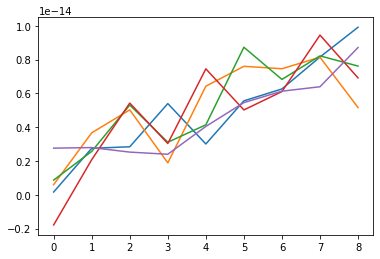

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(facecolor='white')
plt.plot(y_t)
plt.show()

### 2. 安装Allan Variance组件包

In [7]:
# https://allantools.readthedocs.io/en/latest/functions.html
!pip install allantools
import allantools

You should consider upgrading via the 'pip install --upgrade pip' command.


### 3. 生成子钟组

In [9]:
subset_size = 3
if subset_size > y_t.shape[1]:
    raise Exception('The subset size should not be greater than the number of clocks')

### 4. 在滑动窗口内计算协方差矩阵，并计算各子钟组权重

------------------Step 0------------------
*** Raw sum ***
[1.64078209e-15 8.98668110e-15 1.31785461e-14 1.03959499e-14
 1.35719135e-14]
*** Raw sum ***
[-3.07710300e-16  8.31261858e-15  1.57647045e-14  8.03254366e-15
  1.80166761e-14]
*** Raw sum ***
[1.84941728e-15 7.43857732e-15 1.32665269e-14 8.54236683e-15
 1.56377994e-14]
*** Cov mean ***
[[7.74422574e-30 1.11644026e-29 8.26813530e-30]
 [1.11644026e-29 1.75382818e-29 1.29260360e-29]
 [8.26813530e-30 1.29260360e-29 9.62000886e-30]]
*** Corr ***
[[1.         0.95797233 0.95792352]
 [0.95797233 1.         0.99513982]
 [0.95792352 0.99513982 1.        ]]
*** Regularization term ***
[[3.50765636e-31 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.50765636e-31 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.50765636e-31]]
*** Inverse Cov mean ***
[[ 9.40492654e+29 -3.70315492e+29 -2.99817142e+29]
 [-3.70315492e+29  1.02933301e+30 -1.02734016e+30]
 [-2.99817142e+29 -1.02734016e+30  1.68074853e+30]]
*** Weight ***
[[ 1.05762815]
 [-1

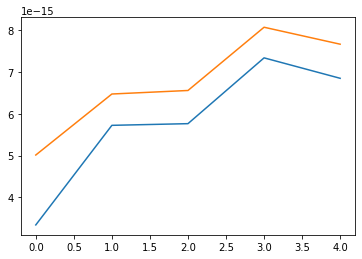

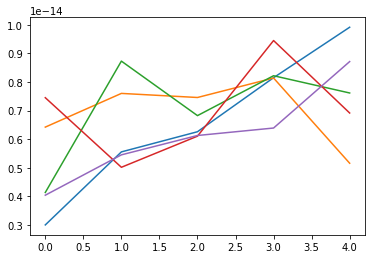

*** Weighted clock's Allan Variance ***
taus - [1.], adevs - [1.4196496e-15]
*** Mean clock's Allan Variance ***
taus - [1.], adevs - [1.12627991e-15]
*** Inverse variance weighted clock's Allan Variance ***
taus - [1.], adevs - [3.7423145e-16]
*** Each clock's Allan Variance ***
taus - [1.], adevs - [8.97090922e-16]
taus - [1.], adevs - [1.622611e-15]
taus - [1.], adevs - [3.08295334e-15]
taus - [1.], adevs - [2.9424519e-15]
taus - [1.], adevs - [9.08922708e-16]


In [10]:
regularization = True
window_size = 5
window_step = 1
A = np.ones((clock_size - subset_size + 1, 1))

if window_size > y_t.shape[0]:
    raise Exception('The window size should not be greater than the number of time points')

weighted_clock_estimation = list()
weighted_inverse_variance_estimation = list()
for i in range(int((y_t.shape[0] - window_size) / window_step) + 1):
    subset_raw_sum_list = list()
    print("------------------Step %s------------------" % i)
    for j in range(y_t.shape[1] - subset_size + 1):
        # 1. Get raw subset
        subset_raw = y_t[i:i+window_size,j:j+subset_size]
        
        # 2. Calculate summation within a subset 
        subset_raw_sum = np.sum(subset_raw, axis=1)
        subset_raw_sum_list.append(subset_raw_sum)
        print("*** Raw sum ***")
        print(subset_raw_sum) 

    # 3. Calculate covariance matrix mean (Element-wise)
    print("*** Cov mean ***")
    allset_cov_mean = np.cov(np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1)
    print(allset_cov_mean)
    print("*** Corr ***")
    allset_corr_mean = np.corrcoef(np.asarray(subset_raw_sum_list))
    print(allset_corr_mean)
    
    # 4. Add regularization term
    if regularization:
        print("*** Regularization term ***")
        sigma = np.max(allset_cov_mean) / (clock_size * 10.0)
        print(sigma * np.eye(clock_size - subset_size + 1))
        allset_cov_mean += sigma * np.eye(clock_size - subset_size + 1)
    
    
    # 5. Calculate the inverse of covariance matrix mean
    print("*** Inverse Cov mean ***")
    allset_cov_mean_inverse = np.linalg.inv(allset_cov_mean)
    print(allset_cov_mean_inverse)
    
    # 6. Calculate weight
    print("*** Weight ***")
    weight = np.dot(allset_cov_mean_inverse, A) / np.dot(np.dot(A.T, allset_cov_mean_inverse), A)
    print(weight)

    # 7. Calculate beamformer weighted clock
    print("*** Weighted output ***")
    Z = (np.dot(weight.T, np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1))[0]
    print(Z)
    
    # 8. Select the last element in Z as the estimation of weighted clock
    weighted_clock_estimation.append(Z[-1])
    
    # 9. Calculate allan variance for each clock
    inverse_variance = list()
    clock_last_row = list()
    for k in range(clock_size):
        clock = y_t[window_step * i:window_step * i + window_size + 1, k]
        (taus, adevs, errors, ns) = allantools.adev(clock)
        inverse_variance.append(1.0 / adevs[0])
        clock_last_row.append(clock[-1])
    inverse_variance = np.array(inverse_variance) / np.sum(np.array(inverse_variance))
    print("*** Inverse variance weight ***")
    print(inverse_variance)
    
    # 10. Calculate the inverse variance weighted clock
    weighted_inverse_variance_clock = np.dot(inverse_variance, np.array(clock_last_row))
    print("*** Inverse variance weighted clock ***")
    print(weighted_inverse_variance_clock)
    weighted_inverse_variance_estimation.append(weighted_inverse_variance_clock)
    
# 11. Visualize weighted clock estimation and each clock
print("------------------Overall------------------")
print("*** Weighted clock estimation ***")
print(weighted_clock_estimation)

print("*** Inverse variance weighted clock estimation ***")
print(weighted_inverse_variance_estimation)

real_clock = y_t[-(int((y_t.shape[0] - window_size) / window_step) + 1):,]
real_clock_mean = np.mean(real_clock, axis=1)
print("*** Mean clock estimation ***")
print(real_clock_mean)

print("*** Clock covariance matrix ***")
print(np.cov(real_clock.T))

print("*** Clock corr matrix ***")
print(np.corrcoef(real_clock.T))

fig = plt.figure(facecolor='white')
plt.plot(weighted_clock_estimation)
plt.plot(real_clock_mean)
plt.show()

fig = plt.figure(facecolor='white')
plt.plot(real_clock)
plt.show()

# 12. Calculate Allan variance
print("*** Weighted clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(weighted_clock_estimation)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Mean clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(real_clock_mean)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Inverse variance weighted clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(weighted_inverse_variance_estimation)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Each clock's Allan Variance ***")
for i in range(real_clock.shape[1]):
    (taus, adevs, errors, ns) = allantools.adev(real_clock[:,i])
    print('taus - %s, adevs - %s' % (taus, adevs))

### 计算R(n)的估计
$ \hat{R}(n)=\frac{1}{(2K+1)(M-L+1)}\sum_{k=-K}^K\sum_{l=0}^{M-L}\bar{X_l}(n-k)\bar{X_l}(n-k)^{H} $